In [2]:
import pystac_client
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import dask.dataframe as dd
import planetary_computer

## Global Variables

In [32]:
#Grid size from HFI ~ 1km at the equator
grid_size = 0.00989273
cr_coods_center = [9.859152, -83.996775]
crs = 'epsg:4326'

In [4]:
import dask_gateway

# cluster = None
gateway = dask_gateway.Gateway()
cluster_options = gateway.cluster_options()



In [5]:

def check_for_existing_clusters():
    if len(gateway.list_clusters()) == 0:
        return False   
    return True

#max is 227
def setup_dask_cluster(max=227, mem=16):
    cluster_options["worker_memory"] = mem
    
    if check_for_existing_clusters():
        print ("Clusters already exist, latching onto the first one")
        
        clusters = gateway.list_clusters()
        cluster = gateway.connect(clusters[0].name)
        
        client = cluster.get_client()
        
    else :
        cluster = gateway.new_cluster(cluster_options, shutdown_on_close=False)
        client = cluster.get_client()
        cluster.adapt(minimum=2, maximum=max)
    
    
    print(client)
    print(cluster.dashboard_link)

    
def shutdown_all_clusters():
    
    clusters = gateway.list_clusters()
    if clusters is not None:
        for c in clusters:
            cluster = gateway.connect(c.name)
            cluster.shutdown()
            print (cluster)
    
# This function will be used to 'override' dask.conpute
# check if dask clusters are alive, if so, latch onto it
# otherwise spawn a new cluster and do .compute on df
def compute(ddf):
    setup_dask_cluster()
    return ddf.compute()

def dashboard():
    return cluster.dashboard_link


### Can reduce the resolution to any arbitrary grid line

This works on pandas or dask frames only

In [6]:
def reduce_resolution_any(ddf, columns, gsize=0.01):
                                
    # ddf[['decimallatitude','decimallongitude']] = ddf[['decimallatitude','decimallongitude']]\
    # .apply(lambda x: gsize * pd.Series.round(x/gsize, 0), meta={'decimallatitude': 'float64', 'decimallongitude': 'float64'},\
    #        axis=1)
    ddf[columns] = ddf[columns].apply(lambda x: gsize * pd.Series.round(x/gsize, 0),axis=1)
    return ddf


### Make a grid around every point in a geopandas frame

Works on geopandas or dask_geopandas frames

In [7]:
import shapely
import numpy as np

def get_square_around_point(point_geom, gsize):
    
    delta_size = gsize / 2.0
    point_coords = np.array(point_geom.coords[0])

    c1 = point_coords + [-delta_size,-delta_size]
    c2 = point_coords + [-delta_size,+delta_size]
    c3 = point_coords + [+delta_size,+delta_size]
    c4 = point_coords + [+delta_size,-delta_size]
    
    square_geom = shapely.geometry.Polygon([c1,c2,c3,c4])
    
    return square_geom

def get_gdf_with_grids(gdf_with_points, gsize=0.01):
    gdf_grid = gdf_with_points.copy()
    gdf_grid['geometry'] = gdf_with_points.apply(lambda row: get_square_around_point(row['geometry'],gsize)\
                                                 ,axis=1)
    return gdf_grid

In [8]:
## High resolution vector boundaries for Costa Rica

In [9]:
countries = gpd.read_file("https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson")
cr_vec_hires = countries[countries.ISO_A2 == 'CR']
cr_vec_hires

,ADMIN,ISO_A3,ISO_A2,geometry
53,Costa Rica,CRI,CR,"MULTIPOLYGON (((-87.09903 5.51602, -87.11767 5..."


/tmp/ipykernel_357/2267075966.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cr_vec_hires.loc['geometry'] = cr_vec_hires['geometry'].set_crs("EPSG:4326")


<AxesSubplot:>

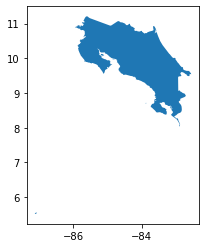

In [24]:
cr_vec_hires.loc['geometry'] = cr_vec_hires['geometry'].set_crs("EPSG:4326")
cr_vec_hires.plot()

In [12]:
cr_bounds = cr_vec_hires.geometry.bounds

Add some buffer around the corners so pixels are not lost

In [29]:
lon_min, lat_min = cr_bounds.iloc[0][0:2] - grid_size*2
lon_max, lat_max = cr_bounds.iloc[0][2:4] + grid_size*2